This notebook walks through the level 1 analyses of a single subject for Developmental differences in learning from large losses study. Details of the behavioral analyses can be found [here](https://zenkavi.github.io/DevStudy_Analyses/output/reports/DevStudy_MG_Behavior.nb.html).


Import packages

In [1]:
import glob
import nibabel as nib
from nistats.first_level_model import FirstLevelModel
import numpy as np
import os
import pandas as pd
import pickle
import re
import sys
sys.path.append(os.environ['SERVER_SCRIPTS'])
from utils.mni2vox import mni2vox
import warnings

Import custom functions

In [2]:
sys.path.append(os.path.join(os.environ['SERVER_SCRIPTS'], 'nistats/level_1'))
from level_1_utils import make_contrasts, add_transform, stdize, get_conditions, get_confounds


Import plotting packages

In [3]:
from matplotlib.colors import ListedColormap
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
from nistats.reporting import plot_design_matrix, plot_contrast_matrix
import nilearn.plotting

%matplotlib inline

# Testing level 1 analysis script

Declare arguments

In [ ]:
subnum = '100003'
pe = True
ev = True
data_loc = os.environ['DATA_LOC']
server_scripts = os.environ['SERVER_SCRIPTS']

Read in events files, make output directories and read in prediction errors

In [ ]:
events_files = glob.glob('%s/sub-*/func/sub-*_task-machinegame_run-*_events.tsv'%(data_loc))
events_files.sort()

out_path = "%s/derivatives/nistats/level_1/sub-%s"%(data_loc,subnum)
if not os.path.exists(out_path):
    os.mkdir(out_path)

contrasts_path = "%s/contrasts"%(out_path)
if not os.path.exists(contrasts_path):
    os.mkdir(contrasts_path)

all_events = pd.DataFrame()

for cur_ef in events_files:
    df = pd.read_csv(cur_ef, sep = '\t')
    all_events = all_events.append(df, ignore_index= True)

all_events = all_events[all_events['response_time'].notnull()]
all_events.response_time = all_events.response_time/1000
mean_rt = all_events.response_time.mean()

del all_events

sub_events = [x for x in events_files if subnum in x]

all_pes = pd.read_csv('%s/rpe_cors/pred_rpes/exp_exp.csv'%(server_scripts))
sub_pes = all_pes.query('sub_id == @subnum')
del all_pes

all_evs = pd.read_csv('%s/rpe_cors/pred_evs/exp_exp.csv'%(server_scripts))
sub_evs = all_evs.query('sub_id == @subnum')
del all_evs

In [ ]:
run_events = sub_events[0]
runnum = re.findall('\d+', os.path.basename(run_events))[1]

#fmri_img: path to preproc_bold that the model will be fit on
fmri_img = os.path.join(data_loc,"derivatives/fmriprep_1.4.0/fmriprep/sub-%s/func/sub-%s_task-machinegame_run-%s_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"%(subnum, subnum, runnum))

#read in preproc_bold for that run
cur_img = nib.load(fmri_img)
cur_img_tr = cur_img.header['pixdim'][4]

#read in events.tsv for that run
cur_events = pd.read_csv(run_events, sep = '\t')
formatted_events = get_conditions(cur_events, runnum, mean_rt, sub_pes, pe, sub_evs, ev)

#process confounds
#['X','Y','Z','RotX','RotY','RotY','<-firsttemporalderivative','stdDVARs','FD','scrub']
cur_confounds = pd.read_csv(os.path.join(data_loc,"derivatives/fmriprep_1.4.0/fmriprep/sub-%s/func/sub-%s_task-machinegame_run-%s_desc-confounds_regressors.tsv"%(subnum, subnum, runnum)), sep='\t')
formatted_confounds = get_confounds(cur_confounds)

#define GLM parmeters
fmri_glm = FirstLevelModel(t_r=cur_img_tr,
                       noise_model='ar1',
                       standardize=False,
                       hrf_model='spm + derivative',
                       drift_model='cosine',
                       smoothing_fwhm=5,
                       mask='%s/derivatives/fmriprep_1.4.0/fmriprep/sub-%s/func/sub-%s_task-machinegame_run-%s_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'%(data_loc, subnum, subnum, runnum))

In [ ]:
max_X = int(runnum)*30
run_evs = sub_evs.query('X<@max_X')
cond_ev = cur_events.query('trial_type == "stim_presentation"')
cond_ev = pd.concat([cond_ev.reset_index(drop=True), run_evs['EV'].reset_index(drop=True)], axis=1)
cond_ev    

In [ ]:
#fit glm to run image using run events
print("***********************************************")
print("Running GLM for sub-%s run-%s"%(subnum, runnum))
print("***********************************************")
fmri_glm = fmri_glm.fit(fmri_img, events = formatted_events, confounds = formatted_confounds)

In [ ]:
design_matrix = fmri_glm.design_matrices_[0]
contrasts = make_contrasts(design_matrix, pe)
contrasts['m1']

In [ ]:
z_map = fmri_glm.compute_contrast(contrasts["m1"], output_type='z_score')

In [ ]:
eff_map = fmri_glm.compute_contrast(contrasts["m1"], output_type='effect_size')

In [ ]:
eff_var_map = fmri_glm.compute_contrast(contrasts["m1"], output_type='effect_variance')

In [ ]:
stat_map = fmri_glm.compute_contrast(contrasts["m1"], output_type='stat')

In [ ]:
z_map_data = z_map.get_fdata()

In [ ]:
eff_map_data = eff_map.get_fdata()

In [ ]:
eff_var_map_data = eff_var_map.get_fdata()

In [ ]:
stat_map_data = stat_map.get_fdata()

In [ ]:
z_map_data.max()

In [ ]:
eff_map_data.max()

In [ ]:
stat_map_data.max()

In [ ]:
tmp1 = nib.load('/oak/stanford/groups/russpold/data/ds000054/0.0.4/derivatives/fsl/level_1/sub-400742/model1/run-001.feat/stats/cope1.nii.gz')

In [ ]:
tmp1.get_fdata().max()

In [ ]:
np.nanmax(eff_map_data/np.sqrt(eff_var_map_data))

In [ ]:
for run_events in sub_events:

    runnum = re.findall('\d+', os.path.basename(run_events))[1]

    exists = os.path.isfile(os.path.join(data_loc,"derivatives/fmriprep_1.4.0/fmriprep/sub-%s/func/sub-%s_task-machinegame_run-%s_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"%(subnum, subnum, runnum)))

    if exists:

        #fmri_img: path to preproc_bold that the model will be fit on
        fmri_img = os.path.join(data_loc,"derivatives/fmriprep_1.4.0/fmriprep/sub-%s/func/sub-%s_task-machinegame_run-%s_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"%(subnum, subnum, runnum))

        #read in preproc_bold for that run
        cur_img = nib.load(fmri_img)
        cur_img_tr = cur_img.header['pixdim'][4]

        #read in events.tsv for that run
        cur_events = pd.read_csv(run_events, sep = '\t')
        formatted_events = get_conditions(cur_events, runnum, mean_rt, sub_pes, pe)

        #process confounds
        #['X','Y','Z','RotX','RotY','RotY','<-firsttemporalderivative','stdDVARs','FD','scrub']
        cur_confounds = pd.read_csv(os.path.join(data_loc,"derivatives/fmriprep_1.4.0/fmriprep/sub-%s/func/sub-%s_task-machinegame_run-%s_desc-confounds_regressors.tsv"%(subnum, subnum, runnum)), sep='\t')
        formatted_confounds = get_confounds(cur_confounds)

        #define GLM parmeters
        fmri_glm = FirstLevelModel(t_r=cur_img_tr,
                               noise_model='ar1',
                               standardize=False,
                               hrf_model='spm + derivative',
                               drift_model='cosine',
                               smoothing_fwhm=5,
                               mask='%s/derivatives/fmriprep_1.4.0/fmriprep/sub-%s/func/sub-%s_task-machinegame_run-%s_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'%(data_loc, subnum, subnum, runnum))

        #fit glm to run image using run events
        print("***********************************************")
        print("Running GLM for sub-%s run-%s"%(subnum, runnum))
        print("***********************************************")
        fmri_glm = fmri_glm.fit(fmri_img, events = formatted_events, confounds = formatted_confounds)

        print("***********************************************")
        print("Saving GLM for sub-%s run-%s"%(subnum, runnum))
        print("***********************************************")
        if pe:
            f = open('%s/sub-%s_run-%s_l1_%s_glm.pkl' %(out_path,subnum, runnum, 'pe'), 'wb')
        else:
            f = open('%s/sub-%s_run-%s_l1_glm.pkl' %(out_path,subnum, runnum), 'wb')
        pickle.dump(fmri_glm, f)
        f.close()

        #Save design matrix
        design_matrix = fmri_glm.design_matrices_[0]
        print("***********************************************")
        print("Saving design matrix for sub-%s run-%s"%(subnum, runnum))
        print("***********************************************")
        if pe:
            design_matrix.to_csv(os.path.join(out_path, 'sub-%s_run-%s_level1_%s_design_matrix.csv' %(subnum, runnum, 'pe')))
        else:
            design_matrix.to_csv(os.path.join(out_path, 'sub-%s_run-%s_level1_design_matrix.csv' %(subnum, runnum)))

        print("***********************************************")
        print("Running contrasts for sub-%s run-%s"%(subnum, runnum))
        print("***********************************************")
        contrasts = make_contrasts(design_matrix, pe)
        for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
            z_map = fmri_glm.compute_contrast(contrast_val, output_type='z_score')
            nib.save(z_map, '%s/sub-%s_run-%s_%s.nii.gz'%(contrasts_path, subnum, runnum, contrast_id))
        print("***********************************************")
        print("Done saving contrasts for sub-%s run-%s"%(subnum, runnum))
        print("***********************************************")

    else:
        print("***********************************************")
        print("No pre-processed BOLD found for sub-%s run-%s"%(subnum, runnum))
        print("***********************************************")

# Outputs of level 1 analyses

Let's look at the outputs  


## Design matrix
Design matrix for the last run

In [ ]:
plt.rcParams['figure.figsize'] = [10, 5]
plot_design_matrix(design_matrix)

Closer look at task regressors

In [ ]:
plot_design_matrix(design_matrix[['m1', 'm2', 'm3', 'm4','m1_rt', 'm2_rt', 'm3_rt', 'm4_rt','hpe', 'lpe']].reset_index(drop=True))

## Correlations between regressors

Correlations between regressors in the design matrix for the last run

In [ ]:
cc=np.corrcoef(design_matrix.T)
plt.imshow(cc,aspect='auto',interpolation='nearest', cmap=plt.cm.viridis)
plt.colorbar()

The highly correlated regressors are motion regressors

In [ ]:
design_matrix.columns[20:40]

## Contrast maps

Let's look at contrast maps for the last run

In [ ]:
zmap_paths = glob.glob('%s/*run-006*'%(contrasts_path))
zmap_paths.sort()

In [ ]:
for t_map in zmap_paths:
    nilearn.plotting.plot_glass_brain(nilearn.image.smooth_img(t_map, 8),
                                      display_mode='lyrz', colorbar=True, plot_abs=False, threshold=2.3, title=os.path.basename(t_map))

In [ ]:
for t_map in zmap_paths:
    nilearn.plotting.plot_stat_map(nilearn.image.smooth_img(t_map, 8), colorbar=True, threshold=2.3, title=os.path.basename(t_map))

For another run the contrast images look like:

In [ ]:
zmap_paths = glob.glob('%s/*run-003*'%(contrasts_path))
zmap_paths.sort()
for t_map in zmap_paths:
    nilearn.plotting.plot_stat_map(nilearn.image.smooth_img(t_map, 8), colorbar=True, threshold=2.3, title=os.path.basename(t_map))

# Extracting z-values 

## Manual extraction

In [ ]:
img_file_name = '%s/sub-%s_run-002_hpe.nii.gz'%(contrasts_path, subnum)
img = nib.load(img_file_name)
mask_file_name = '/oak/stanford/groups/russpold/data/ds000054/0.0.4/derivatives/rois/tpl-MNI152NLin2009cAsym_res-01_desc-brain_T1w/l_vstr_bin.nii.gz'
mask = nib.load(mask_file_name)

Extract ROI data manually as in: https://neurostars.org/t/extract-roi-voxels-using-nilearns-niftimasker/3977  

**Doesn't work because the BOLD does not have the same dimensionality**

In [ ]:
img_data = img.get_fdata()
mask_data = mask.get_fdata()
roi_nifti_data = np.where(mask_data == 1,img_data,0)
roi_nifti_img = image.new_img_like(img,roi_nifti_data)

In [ ]:
img_data.shape == mask_data.shape

Resample mask to statistical map  

Note: the resampled image is not longer binarized

In [ ]:
res_mask = nilearn.image.resample_to_img(mask, img)
res_mask_data = res_mask.get_fdata()
#binarize resampled mask data
res_mask_data = np.where(res_mask_data >0.1,1,0)
res_mask = nilearn.image.new_img_like(img, res_mask_data)

In [ ]:
nilearn.plotting.plot_stat_map(res_mask, colorbar=True, draw_cross=False)

Does it matter which contrast image the ROI is resampled to?

In [ ]:
img2_file_name = '/oak/stanford/groups/russpold/data/ds000054/0.0.4/derivatives/nistats/level_1/sub-407209/contrasts/sub-407209_run-002_hpe.nii.gz'
img2 = nib.load(img2_file_name)
res2_mask = nilearn.image.resample_to_img(mask, img2)
res2_mask_data = res2_mask.get_fdata()
#binarize resampled mask data
res2_mask_data = np.where(res2_mask_data >0.1,1,0)
res2_mask = nilearn.image.new_img_like(img2, res2_mask_data)
nilearn.plotting.plot_stat_map(res2_mask, colorbar=True, draw_cross=False)

No. The resampled mask seems the same regardless of what contrast image it is registered to

In [ ]:
(res_mask_data != res2_mask_data).sum()

In [ ]:
img_data = img.get_fdata()
roi_nifti_data = np.where(res_mask_data == 1,img_data,0)
roi_nifti_img = nilearn.image.new_img_like(img,roi_nifti_data)

In [ ]:
nilearn.plotting.plot_stat_map(roi_nifti_img, colorbar=True, draw_cross=False)

In [ ]:
roi_data = roi_nifti_data[roi_nifti_data != 0]
cur_betas = pd.DataFrame()
cur_betas["beta"] = roi_data


In [ ]:
models = glob.glob(os.path.join(server_scripts, 'rpe_cors/pred_rpes/*.csv'))
models = [os.path.splitext(os.path.basename(x))[0] for x in models]
model = models[7]
beta_img_paths = glob.glob('%s/derivatives/rpe_cors/%s/sub-*/contrasts/sub-*_run-*_*pe_betas.nii.gz'%(data_loc, model))
cur_beta_img = beta_img_paths[10]
os.path.basename(cur_beta_img).split("_")[2]

In [ ]:
nilearn.plotting.plot_stat_map(img, colorbar=True, threshold=2.3, draw_cross=False, cut_coords=[-11,13,-6])

In [ ]:
nilearn.plotting.plot_stat_map(img, colorbar=True, threshold=2.3, draw_cross=False, cut_coords=[-11,13,-6])

## Using freesurfer

Extract using freesurfer segmentation as described in https://groups.google.com/forum/#!topic/nipy-user/DjnN9q52vH8

**Not working due to broken freesurfer path**

In [ ]:
import nipype.interfaces.freesurfer as fs 
segstat = fs.SegStats() 
segstat.inputs.segmentation_file = mask_file_name 
segstat.inputs.in_file = img_file_name 
segstat.inputs.avgwf_file = True 
segstat.run() 

# Check dimensions of fmriprep output

In [ ]:
nib.load('/oak/stanford/groups/russpold/data/ds000054/0.0.4/derivatives/rois/tpl-MNI152NLin2009cAsym_res-01_desc-brain_T1w/tpl-MNI152NLin2009cAsym_res-01_desc-brain_T1w.nii.gz').shape

In [ ]:
nib.load(data_loc+'/derivatives/fmriprep_1.4.0/fmriprep/sub-400742/func/sub-400742_task-machinegame_run-005_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz').shape

In [ ]:
nib.load(data_loc+'/derivatives/fmriprep_1.4.0/fmriprep/sub-100003/func/sub-100003_task-machinegame_run-002_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz').shape

In [ ]:
nib.load(data_loc+'/derivatives/fmriprep_1.3.0/fmriprep/sub-400742/anat/sub-400742_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz').shape

In [ ]:
nib.load('/home/users/zenkavi/datalad/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-02_desc-brain_T1w.nii.gz').shape

In [ ]:
tmp_path = '/oak/stanford/groups/russpold/users/ieisenbe/uh2/fmri_data/BIDS_data/derivatives/fmriprep/fmriprep/sub-s061/ses-1/func'
nib.load(tmp_path+'/sub-s061_ses-1_task-stopSignal_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz').shape

In [ ]:
tmp_path = '/oak/stanford/groups/russpold/data/ds000054/0.0.4/sub-400742/func'
nib.load(tmp_path+'/sub-400742_task-machinegame_run-001_bold.nii.gz').shape

In [ ]:
tmp_path = '/oak/stanford/groups/russpold/data/ds000054/0.0.4/sub-400742/anat'
nib.load(tmp_path+'/sub-400742_T1w.nii.gz').shape

In [ ]:
nib.load('/oak/stanford/groups/russpold/data/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_desc-brain_T1w.nii.gz').shape

# Effect_size maps

- Get to the bottom of `effect_size` maps in nistats
    - For level 1's run regressions of time series of voxel ~ design matrix
    - Do this regression for both nistats AND fsl (using its own design matrix) to understand what the values are

In [12]:
import statsmodels.api as sm
from sklearn.preprocessing import scale
from nibabel.processing import smooth_image
from scipy.stats.mstats import zscore

In [32]:
data_loc = os.environ['DATA_LOC']
subnum = '200148'
runnum = '002'
reg = "m1"
fmriprep_path = '%s/derivatives/fmriprep_1.4.0/fmriprep' %(data_loc)
raw_img = nib.load('%s/sub-%s/func/sub-%s_task-machinegame_run-%s_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'%(fmriprep_path, subnum, subnum, runnum))
ns_path = '%s/derivatives/rpe_cors/exp_exp' %(data_loc)
ns_z_img = nib.load("%s/sub-%s/contrasts/sub-%s_run-%s_%s.nii.gz"%(ns_path, subnum, subnum, runnum, reg))
ns_b_img = nib.load("%s/sub-%s/contrasts/sub-%s_run-%s_%s_betas.nii.gz"%(ns_path, subnum, subnum, runnum, reg))
ns_design = pd.read_csv('%s/sub-%s/sub-%s_run-%s_level1_pe_design_matrix.csv'%(ns_path, subnum, subnum, runnum))
ns_design = ns_design.drop(columns=["Unnamed: 0"])
fsl_path = '%s/derivatives/fsl/level_1' %(data_loc)
fsl_t_img = nib.load('%s/sub-%s/model1/run-%s.feat/stats/tstat1.nii.gz'%(fsl_path, subnum, runnum))
fsl_z_img = nib.load('%s/sub-%s/model1/run-%s.feat/stats/zstat1.nii.gz'%(fsl_path, subnum, runnum))
fsl_cope_img = nib.load('%s/sub-%s/model1/run-%s.feat/stats/cope1.nii.gz'%(fsl_path, subnum, runnum))
fsl_filtered_func = nib.load('%s/sub-%s/model1/run-%s.feat/filtered_func_data.nii.gz'%(fsl_path, subnum, runnum))
fsl_design = pd.read_csv('%s/sub-%s/model1/run-%s.feat/design.tsv'%(fsl_path, subnum, runnum), sep="\t", header=None)
fsl_design=fsl_design.drop(columns=fsl_design.columns[23])

In [8]:
smooth_img = smooth_image(raw_img, 5)

In [73]:
vox_ts = smooth_img.get_fdata()[19,60,35]

In [74]:
ns_z_img.get_fdata()[19,60,35]

0.22778420397516183

In [75]:
ns_b_img.get_fdata()[19,60,35]

0.19938380575277337

In [77]:
ns_b_img.get_fdata()[19,60,35]*ns_design.m1.std()

0.01728503240450035

So to convert `effect_size` images to betas you can multiply the unstandardized beta image you have with the std of the regressor from the design matrix (posted on neurostars to verify)

In [76]:
model = sm.OLS(scale(vox_ts), ns_design).fit()
#for betas you would you do
#model = sm.OLS(scale(vox_ts), scale(ns_design)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     4.035
Date:                Wed, 24 Jul 2019   Prob (F-statistic):           6.76e-12
Time:                        11:41:10   Log-Likelihood:                -218.68
No. Observations:                 216   AIC:                             541.4
Df Residuals:                     164   BIC:                             716.9
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
hpe                           -0.0038      0.034     -0.112      0.911      -0.071       0.063
hpe_derivative                 0.0647      0.120      0.540      0.590      -0.172       0.301
junk                          -0.5945      0.407     -1.460      0.146      -1.399       0.210
junk_derivative                0.2476      1.521      0.163      0.871      -2.756       3.251
lpe                            0.0170      0.009      1.845      0.067      -0.001       0.035
lpe_derivative                -0.0276      0.026     -1.052      0.294      -0.079       0.024
m1                             0.2808      1.194      0.235      0.814      -2.076       2.638
m1_derivative                 -0.9423      1.984     -0.475      0.635      -4.859       2.974
m1_rt                         -0.4298      1.306     -0.329      0.742      -3.008       2.149
m1_rt_derivative               2.3557      3.245      0.726      0.469      -4.052       8.763
m2                            -1.0212      1.690     -0.604      0.547      -4.359       2.316
m2_derivative                 -1.0186      3.488     -0.292      0.771      -7.906       5.869
m2_rt                          2.8258      1.706      1.656      0.100      -0.543       6.195
m2_rt_derivative              -0.8037      4.395     -0.183      0.855      -9.482       7.874
m3                            -0.4952      1.389     -0.357      0.722      -3.238       2.248
m3_derivative                  0.5782      2.315      0.250      0.803      -3.993       5.149
m3_rt                          1.0230      1.060      0.965      0.336      -1.070       3.116
m3_rt_derivative               0.3407      2.613      0.130      0.896      -4.819       5.501
m4                             0.9349      1.559      0.600      0.549      -2.143       4.012
m4_derivative                  2.6561      3.302      0.804      0.422      -3.865       9.177
m4_rt                          1.9887      2.572      0.773      0.440      -3.089       7.066
m4_rt_derivative              -2.5018      7.288     -0.343      0.732     -16.892      11.889
trans_x                        4.8373     25.269      0.191      0.848     -45.058      54.732
trans_x_derivative1            8.1949      9.834      0.833      0.406     -11.224      27.613
trans_x_derivative1_power2  -113.5410    574.953     -0.197      0.844   -1248.806    1021.724
trans_x_power2               -33.9255    361.908     -0.094      0.925    -748.525     680.674
trans_y                        3.0397     14.628      0.208      0.836     -25.843      31.923
trans_y_derivative1            7.2159      2.968      2.431      0.016       1.356      13.076
trans_y_derivative1_power2    37.8276     32.697      1.157      0.249     -26.733     102.389
trans_y_power2               -27.0442     3

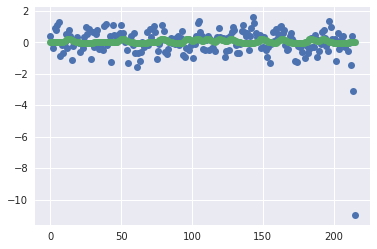

In [22]:
#plt.plot(scale(ns_design.m1), scale(vox_ts), 'o', label='data')
plt.plot(np.arange(0, 216), scale(vox_ts), 'o', label='data')
plt.plot(np.arange(0, 216), ns_design.m1, 'o', label='data')

In [23]:
fsl_smooth_filtered_func = nib.processing.smooth_image(fsl_filtered_func, 5)
fsl_vox_ts = fsl_smooth_filtered_func.get_fdata()[19,70,50]

In [24]:
fsl_t_img.get_fdata()[19,70,50]

0.11769688874483109

In [25]:
fsl_z_img.get_fdata()[19,70,50]

0.11754161864519119

In [26]:
fsl_cope_img.get_fdata()[19,70,50]

11.627188682556152

In [38]:
fsl_design = sm.add_constant(fsl_design)
model = sm.OLS(fsl_vox_ts, fsl_design).fit()
model.summary()

/home/groups/russpold/software/miniconda/envs/fmri/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/groups/russpold/software/miniconda/envs/fmri/lib/python3.5/site-packages/statsmodels/regression/linear_model.py:1633: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/home/groups/russpold/software/miniconda/envs/fmri/lib/python3.5/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/home/groups/russpold/software/miniconda/envs/fmri/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/groups/russpold/software/miniconda/envs/fmri/lib/python3.5/site-packages/scipy/stats/_distn_infras

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.120
Date:                Wed, 24 Jul 2019   Prob (F-statistic):              0.329
Time:                        11:04:46   Log-Likelihood:                -1175.1
No. Observations:                 216   AIC:                             2394.
Df Residuals:                     194   BIC:                             2468.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4413.5344      4.004   1102.370      0.000    4405.638    4421.431
0             31.4964     84.890      0.371      0.711    -135.930     198.923
1             33.1820    173.002      0.192      0.848    -308.025     374.389
2            -14.4927    123.387     -0.117      0.907    -257.845     228.859
3            -54.2238    266.698     -0.203      0.839    -580.224     471.777
4             17.1429     89.100      0.192      0.848    -158.585     192.871
5            134.7108    191.547      0.703      0.483    -243.071     512.492
6            146.1188     98.442      1.484      0.139     -48.035     340.273
7            128.5884    223.965      0.574      0.567    -313.130     570.307
8             87.6505     77.882      1.125      0.262     -65.953     241.254
9            -81.7225    224.631     -0.364      0.716    -524.755     361.310
10          -136.5304    128.485     -1.063      0.289    -389.937     116.877
11          -236.7896    344.654     -0.687      0.493    -916.540     442.961
12            61.9773     58.610      1.057      0.292     -53.617     177.571
13          -110.7505    177.981     -0.622      0.535    -461.777     240.276
14           150.6902    164.789      0.914      0.362    -174.317     475.698
15           479.3904    527.157      0.909      0.364    -560.305    1519.086
16             2.0420      1.469      1.390      0.166      -0.856       4.940
17             2.7709      5.623      0.493      0.623      -8.318      13.860
18           -34.6260     47.662     -0.726      0.468    -128.629      59.377
19           268.0172    151.526      1.769      0.079     -30.833     566.868
20                  0          0        nan        nan           0           0
21                  0          0        nan        nan           0           0
22           -52.0357     39.722     -1.310      0.192    -130.378      26.307
==============================================================================
Omnibus:                       14.768   Durbin-Watson:                   1.630
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               42.277
Skew:                          -0.053   Prob(JB):                     6.60e-10
Kurtosis:                       5.165   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
plt.plot(np.arange(0, 216), scale(vox_ts), 'o', label='data')
plt.plot(np.arange(0, 216), fsl_design.iloc[:,1], 'o', label='data')

In [ ]:
#the m1 regressor is almost identical in both design matrices
plt.plot(fsl_design.iloc[:,1], ns_design.m1, 'o', label='data')

In [ ]:
plt.plot(fsl_filtered_func.get_fdata()[19,70,50], vox_ts, 'o', label='data')